In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, classification_report, roc_curve, confusion_matrix, precision_recall_curve, auc, recall_score, precision_score, average_precision_score, fbeta_score, plot_precision_recall_curve
from mlxtend.evaluate import bias_variance_decomp

import warnings
warnings.filterwarnings("ignore")

# Load train & test datasets

In [2]:
#Load the train data
data_train = pd.read_csv('train_AvX1lTZ.csv')
data_test = pd.read_csv('test_tERCnnc.csv')

In [3]:
data_train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
data_test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,36306,Male,80.0,0,0,Yes,Private,Urban,83.84,21.1,formerly smoked
1,61829,Female,74.0,0,1,Yes,Self-employed,Rural,179.50,26.0,formerly smoked
2,14152,Female,14.0,0,0,No,children,Rural,95.16,21.2,NaN
3,12997,Male,28.0,0,0,No,Private,Urban,94.76,23.4,NaN
4,40801,Female,63.0,0,0,Yes,Govt_job,Rural,83.57,27.6,never smoked


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [6]:
# Get the list of numerical & categorical columns
numerical_cols = list(data_train.select_dtypes(include=['int64', 'float']).columns)
data_train[numerical_cols].describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


In [7]:
categorical_cols = list(data_train.select_dtypes(include=['object']).columns)
data_train[categorical_cols].describe()

,gender,ever_married,work_type,Residence_type,smoking_status
count,43400,43400,43400,43400,30108
unique,3,2,5,2,3
top,Female,Yes,Private,Urban,never smoked
freq,25665,27938,24834,21756,16053


We are creating the 'age_group' feature upfront because we can potential use this to impute the missing values for BMI & smoking_status.

In [8]:
# Convert age into age_groups and see if BMI is different across the age groups
bins = [0,10,30,50,70,100]
names = ['child', 'young_adult', 'adult', 'senior', 'super_senior']
data_train['age_group'] = pd.cut(data_train['age'], bins, labels=names)
data_test['age_group'] = pd.cut(data_test['age'], bins, labels=names)

In [9]:
# BMI - groupwise mean values for various age groups, gender
data_train.pivot_table('bmi', ['age_group', 'gender'], aggfunc='mean')

bmi
age_group    gender           
child        Female  18.697910
             Male    19.025108
             Other   21.200000
young_adult  Female  27.291503
             Male    26.542101
             Other   24.233333
adult        Female  30.625622
             Male    31.488686
             Other   34.600000
senior       Female  31.299237
             Male    31.368295
             Other   32.200000
super_senior Female  28.704496
             Male    28.983879

In [10]:
# Do a pivot for smoking_status & see it the mode() value changes to the individual groups
data_train.pivot_table('id', ['age_group', 'gender'], 'smoking_status', aggfunc='count', dropna=False, observed=True)

smoking_status       formerly smoked  never smoked  smokes
age_group    gender                                       
child        Female              8.0          35.0     NaN
             Male                7.0          27.0     1.0
             Other               1.0           NaN     NaN
young_adult  Female            643.0        2732.0   857.0
             Male              332.0        1446.0   510.0
             Other               3.0           NaN     1.0
adult        Female           1122.0        3373.0  1421.0
             Male              768.0        1804.0  1070.0
             Other               1.0           2.0     NaN
senior       Female           1536.0        3015.0  1132.0
             Male             1436.0        1587.0  1025.0
             Other               1.0           NaN     NaN
super_senior Female            808.0        1413.0   271.0
             Male              827.0         619.0   274.0
             Other               NaN           NaN     NaN

# Impute missing values

In [9]:
# Impute the missing values for bmi & smoking_status (BASE MODEL IMPUTING WITH OVERALL MEAN & MODE VALUES)
def impute_data(df, imputetype):
    if imputetype == 'default':
        # Get the mean value for bmi
        df['bmi'].fillna(value=df['bmi'].mean(), inplace=True)

        # Get the mode for smoking_status
        df['smoking_status'].fillna(value=df['smoking_status'].mode()[0], inplace=True)
    
    if imputetype == 'groupbased':
        # Get the group wise mean for bmi
        df['bmi'] = df.groupby(['age_group','gender'])['bmi'].transform(lambda x: x.fillna(x.mean()))

        #Get the group wise mode for smoking_status
        # Mode() for 60+ Male is 'formerly smoked' based on the pivot
        df['smoking_status'] = np.where((df['age_group']=='60+') & (df['gender']=='Male') & (df['smoking_status'].isnull()==True),'formerly smoked',df['smoking_status'])

        # For all other groups the mode value is 'never smoked'
        df['smoking_status'].fillna(value=df['smoking_status'].mode()[0], inplace=True)
    
    return df

In [10]:
data_train = impute_data(data_train, 'default')
data_test = impute_data(data_test, 'default')

# Categorical features - Encoding

In [11]:
# Onehot encoding
def encode(df, cat_cols):
#     cat_cols = ['gender','ever_married', 'Residence_type','smoking_status','work_type','age_group']

    for col in cat_cols:
        df = pd.concat([df,pd.get_dummies(df[col],prefix = str(col),prefix_sep='_', drop_first=True)],axis = 1)
        df = df.drop(col, axis=1)

    return df
    

# Feature Engineering

In [12]:
def add_features(df):

    # Convert age into age_groups and see if BMI is different across the age groups
#     bins = [0,10,30,50,70,100]
#     names = ['child', 'young_adult', 'adult', 'senior', 'super_senior']
#     df['age_group'] = pd.cut(df['age'], bins, labels=names)
    
    bins = [0,18.5,25,30,100]
    names = ['under_weight', 'healthy', 'over_weight', 'obese']
    df['bmi_status'] = pd.cut(df['bmi'], bins, labels=names)
    
    bins = [0,140,200,400]
    names = ['normal', 'prediabetic', 'diabetic']
    df['diabetes'] = pd.cut(df['avg_glucose_level'], bins, labels=names)
    
    df = encode(df, ['age_group', 'bmi_status', 'diabetes'])
    
    # Age_group (senior, super_senior) + Hypertension
    a = (df['age_group_senior'] == '1')
    b= (df['hypertension'] == '1')
    df['age_senior_hypertension'] = a & b
    
    a = (df['age_group_super_senior'] == '1')
    b= (df['hypertension'] == '1')
    df['age_super_senior_hypertension'] = a & b
    
     # Age_group (senior, super_senior) + Heart_disease
    a = (df['age_group_senior'] == '1')
    b= (df['heart_disease'] == '0')
    df['age_senior_no_heartdisease'] = a & b
    
    a = (df['age_group_super_senior'] == '1')
    b= (df['heart_disease'] == '0')
    df['age_super_senior_no_heartdisease'] = a & b
    
    # Age_group + Diabetes
    a = (df['age_group_super_senior'] == '1')
    b= (df['diabetes_diabetic'] == '1')
    df['age_super_senior_diabetic'] = a & b

    a = (df['age_group_super_senior'] == '1')
    b= (df['diabetes_prediabetic'] == '1')
    df['age_super_senior_prediabetic'] = a & b

    a = (df['age_group_senior'] == '1')
    b= (df['diabetes_diabetic'] == '1')
    df['age_senior_diabetic'] = a & b

    a = (df['age_group_senior'] == '1')
    b= (df['diabetes_prediabetic'] == '1')
    df['age_senior_prediabetic'] = a & b

    # Age-group + Ever_married
    a = (df['age_group_senior'] == '1')
    b= (df['ever_married_Yes'] == '1')
    df['age_senior_married'] = a & b
    
    a = (df['age_group_super_senior'] == '1')
    b= (df['ever_married_Yes'] == '1')
    df['age_super_senior_married'] = a & b

    # Age-group + Work_type
    a = (df['age_group_senior'] == '1')
    b= (df['work_type_Private'] == '1')
    df['age_senior_private'] = a & b
    
    a = (df['age_group_super_senior'] == '1')
    b= (df['work_type_Private'] == '1')
    df['age_super_senior_private'] = a & b

    a = (df['age_group_super_senior'] == '1')
    b= (df['work_type_Self-employed'] == '1')
    df['age_super_senior_selfemployed'] = a & b
    
    # Age-group + Gender
    a = (df['age_group_super_senior'] == '1')
    b= (df['gender_Male'] == '1')
    df['age_super_senior_Male'] = a & b
    
    a = (df['age_group_senior'] == '1')
    b= (df['gender_Male'] == '1')
    df['age_senior_Male'] = a & b
    
    # Age-group + BMI_Group
    a = (df['age_group_super_senior'] == '1')
    b= (df['bmi_status_over_weight'] == '1')
    df['age_super_senior_over_weight'] = a & b

    a = (df['age_group_super_senior'] == '1')
    b= (df['bmi_status_obese'] == '1')
    df['age_super_senior_obese'] = a & b
    
    a = (df['age_group_super_senior'] == '1')
    b= (df['bmi_status_healthy'] == '1')
    df['age_super_senior_healthy'] = a & b
    
    a = (df['age_group_senior'] == '1')
    b= (df['bmi_status_obese'] == '1')
    df['age_senior_obese'] = a & b

    a = (df['age_group_senior'] == '1')
    b= (df['bmi_status_over_weight'] == '1')
    df['age_senior_over_weight'] = a & b

    # Age-group + Residence_type
    a = (df['age_group_super_senior'] == '1')
    b= (df['Residence_type_Urban'] == '1')
    df['age_super_senior_Urban'] = a & b

    a = (df['age_group_senior'] == '1')
    b= (df['Residence_type_Urban'] == '1')
    df['age_senior_Urban'] = a & b
    
    # Age-group + Smoking_Status
    a = (df['age_group_super_senior'] == '1')
    b= (df['smoking_status_never smoked'] == '1')
    df['age_super_senior_never_smoked'] = a & b
    
    a = (df['age_group_senior'] == '1')
    b= (df['smoking_status_never smoked'] == '1')
    df['age_senior_never_smoked'] = a & b
    
    # Hypertenson + Heart_disease
    a = (df['heart_disease'] == '0')
    b = (df['hypertension'] == '0')
    df['no_hypertension_no_heartdisease'] = a & b
    
    # Married + Hypertension
    a = (df['ever_married_Yes'] == '1')
    b = (df['hypertension'] == '0')
    df['married_no_hypertension'] = a & b

    # Married + Work_type
    a = (df['ever_married_Yes'] == '1')
    b = (df['work_type_Private'] == '1')
    df['married_private'] = a & b

    a = (df['ever_married_Yes'] == '1')
    b = (df['work_type_Self-employed'] == '1')
    df['married_Self-employed'] = a & b
    
    # Married + Smoking_status
    a = (df['ever_married_Yes'] == '1')
    b = (df['smoking_status_never smoked'] == '1')
    df['married_never_smoked'] = a & b

    # Married + Residence_type
    a = (df['ever_married_Yes'] == '1')
    b = (df['Residence_type_Urban'] == '1')
    df['married_Urban'] = a & b
    
    # Married + Gender
    a = (df['ever_married_Yes'] == '1')
    b = (df['gender_Male'] == '1')
    df['married_Male'] = a & b
    
    # Married + BMI
    a = (df['ever_married_Yes'] == '1')
    b = (df['bmi_status_obese'] == '1')
    df['married_obese'] = a & b

    a = (df['ever_married_Yes'] == '1')
    b = (df['bmi_status_over_weight'] == '1')
    df['married_over_weight'] = a & b

    # Married + Diabetes
    a = (df['ever_married_Yes'] == '1')
    b = (df['diabetes_diabetic'] == '1')
    df['married_diabetic'] = a & b

    # Married + Heart_disease
    a = (df['ever_married_Yes'] == '1')
    b = (df['heart_disease'] == '0')
    df['married_no_heartdisease'] = a & b
    
    #Summing up age,bmi and avg_gulcose level columns
    df['age_bmi_gulcose'] = df['age']+ df['bmi']+ df['avg_glucose_level']   

    # avg_glucose_level to age ratio
    df['avg_glucose_level_age_ratio'] = df['avg_glucose_level']/df['age']    
    
    # bmi to age ratio
    df['bmi_age_ratio'] = df['bmi']/df['age']    
    
    # BMI + Diabetes
    a = (df['bmi_status_obese'] == '1')
    b = (df['diabetes_diabetic'] == '1')
    df['obese_diabetic'] = a & b
    
    a = (df['bmi_status_over_weight'] == '1')
    b = (df['diabetes_diabetic'] == '1')
    df['over_weight_diabetic'] = a & b
    
    df = df.replace(True, 1)
    df = df.replace(False, 0)
    
    return df

Combine the test & train datasets so that we can add new features & also encode them (if needed) together

In [13]:
# Combine the train & test dataset
df = data_train.append(data_test,ignore_index=True)
df.shape

(62001, 13)

In [14]:
# Encode the categorical features
cols = ['gender','ever_married', 'Residence_type','smoking_status','work_type']
df = encode(df, cols)

In [15]:
df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,age_group,gender_Male,gender_Other,ever_married_Yes,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,30669,3.0,0,0,95.12,18.0,0.0,child,1,0,0,0,1,0,0,0,0,1
1,30468,58.0,1,0,87.96,39.2,0.0,senior,1,0,1,1,1,0,0,1,0,0
2,16523,8.0,0,0,110.89,17.6,0.0,child,0,0,0,1,1,0,0,1,0,0
3,56543,70.0,0,0,69.04,35.9,0.0,senior,0,0,1,0,0,0,0,1,0,0
4,46136,14.0,0,0,161.28,19.1,0.0,young_adult,1,0,0,0,1,0,1,0,0,0


In [16]:
df.dtypes

id                                int64
age                             float64
hypertension                      int64
heart_disease                     int64
avg_glucose_level               float64
bmi                             float64
stroke                          float64
age_group                      category
gender_Male                       uint8
gender_Other                      uint8
ever_married_Yes                  uint8
Residence_type_Urban              uint8
smoking_status_never smoked       uint8
smoking_status_smokes             uint8
work_type_Never_worked            uint8
work_type_Private                 uint8
work_type_Self-employed           uint8
work_type_children                uint8
dtype: object

In [17]:
# Add new features based on the existing features
df = add_features(df)

In [18]:
df.dtypes

id                               int64
age                            float64
hypertension                     int64
heart_disease                    int64
avg_glucose_level              float64
                                ...   
age_bmi_gulcose                float64
avg_glucose_level_age_ratio    float64
bmi_age_ratio                  float64
obese_diabetic                 float64
over_weight_diabetic           float64
Length: 66, dtype: object

In [18]:
numerical_cols = df.select_dtypes(include=['int64', 'uint8']).columns
df[numerical_cols] = df[numerical_cols].astype('float64')

In [19]:
# Split the train & test datasets
data_train = df[df['stroke'].isnull()!=True]
data_test = df[df['stroke'].isnull()==True]

data_test = data_test.drop(['stroke'], axis = 1)
data_test.reset_index(inplace=True)

data_train.shape, data_test.shape

((43400, 66), (18601, 66))

# Scaling - Numerical features

In [20]:
# Function to use different scalers
def scale_data(df, cols, scaler):
    #initialize the scaler based on the input provided
    if scaler == 'StandardScaler':
        scaler_to_use = StandardScaler()
    if scaler == 'MinMaxScaler':
        scaler_to_use = MinMaxScaler()
    if scaler == 'Normalizer':
        scaler_to_use = Normalizer()
    else:
        scaler_to_use = StandardScaler()
    
    # Get the column names from X
    cols = list(cols)
    
    # Fit the scaler to the train set to get mean & std values in case of StandardScaler()
    df_scaled = scaler_to_use.fit_transform(df[cols])
    df_scaled = pd.DataFrame(df_scaled, columns=cols)
    
    #return the scaled dataframe
    return df_scaled

In [21]:
# Scale the numerical columns (TRAIN Dataset)
cols = ['age', 'avg_glucose_level', 'bmi', 'age_bmi_gulcose', 'avg_glucose_level_age_ratio', 'bmi_age_ratio']
# cols = data_train.columns
X_scaled = scale_data(data_train, cols, 'StandardScaler')

# Merge the 3 scaled columns with x_train & x_test
X_orig = data_train.drop(columns = cols, axis = 1)
data_train = pd.merge(X_scaled, X_orig, left_index=True, right_index=True)

# Model Building - Prepare the train & validation sets

In [22]:
# Split the independent & dependent variables
X = data_train.drop(['id','stroke'], axis=1)
y = data_train['stroke']

# Split the train & test data
x_train, x_test, y_train, y_test = train_test_split(X,y,random_state=42, stratify=y, test_size=0.2)
x_train.head()

,age,avg_glucose_level,bmi,age_bmi_gulcose,avg_glucose_level_age_ratio,bmi_age_ratio,hypertension,heart_disease,gender_Male,gender_Other,...,married_Self-employed,married_never_smoked,married_Urban,married_Male,married_obese,married_over_weight,married_diabetic,married_no_heartdisease,obese_diabetic,over_weight_diabetic
1364,-1.119830,0.265528,-0.694564,-0.341077,-0.029825,-0.058751,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31728,1.544540,0.305657,-0.380343,0.805581,-0.171199,-0.212647,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29547,-0.675769,0.713439,-0.629102,0.191932,-0.078199,-0.131349,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9701,0.256761,-0.424083,1.177669,-0.062682,-0.164045,-0.145918,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18917,-0.409331,-0.176584,0.693245,-0.206260,-0.133596,-0.109709,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[4, 3])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=['Predicted: No (F)','Predicted: Yes (T)'], yticklabels=['Actual: No (F)','Actual: Yes (T)'])


In [24]:
# We are creating an empty list of best features to begin with. When it's empty the model will be fitted on all the features. 
# Later we will do feature selection and update this list. Then the model can be built on those selected features.
best_features = ""

# Fit the model and gather the evaluation metrics

Classification report for Test:
              precision    recall  f1-score   support

     class 0       0.99      0.86      0.92      8523
     class 1       0.08      0.62      0.14       157

    accuracy                           0.86      8680
   macro avg       0.53      0.74      0.53      8680
weighted avg       0.98      0.86      0.91      8680

F1-Score =  0.13754385964912283
Recall score =  0.6242038216560509
ROC_AUC Score =  0.7434641072377404


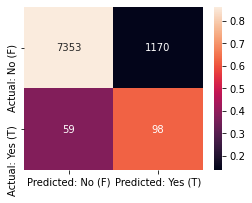

In [62]:
# Build the Logistic Regression model
lr = LogisticRegression(class_weight={0: 0.04, 1:0.96}) # based on the earlier step we figured that the f1-score was max for weight = 0.94 for the minority class
# lr = LogisticRegression(class_weight='balanced')

if best_features != "":
    x_train = x_train[best_features]
    x_test = x_test[best_features]

# Fit the training data
lr.fit(x_train,y_train)
    
# Predict training score
y_train_pred = lr.predict(x_train)
#     print("Classification report for Training:", classification_report(y_train, y_train_pred, target_names=['class 0','class 1']), sep="\n")
    
# Predict test score
y_test_pred = lr.predict(x_test)
print("Classification report for Test:", classification_report(y_test, y_test_pred, target_names=['class 0','class 1']), sep="\n")
    
f1_test = f1_score(y_test, y_test_pred)
print("F1-Score = ", f1_test)
recall = recall_score(y_test, y_test_pred)
print("Recall score = ", recall)
print("ROC_AUC Score = ", roc_auc_score(y_test, y_test_pred))
 
cm_train = confusion_matrix(y_train,y_train_pred) 
cm_test = confusion_matrix(y_test,y_test_pred)
    
# plot_confusion_matrix(cm_train, ['No', 'Yes'])
plot_confusion_matrix(cm_test, ['No', 'Yes'])

tn, fp, fn, tp = cm_test.ravel()

tn_tr, fp_tr, fn_tr, tp_tr = cm_train.ravel()
false_positive_rate_tr = fp_tr / (fp_tr + tn_tr)
false_negative_rate_tr = fn_tr / (tp_tr + fn_tr)

false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (tp + fn)


In [48]:
# Calculate the ROC-AUC Score and plot the ROC-AUC Curve
y_test_pred_proba = lr.predict_proba(x_test)[:,1]
y_train_pred_proba = lr.predict_proba(x_train)[:,1]

fpr_train, tpr_train, _train = roc_curve(y_train, y_train_pred_proba) 
fpr_test, tpr_test, _test = roc_curve(y_test, y_test_pred_proba) 

auc_train = roc_auc_score(y_train, y_train_pred_proba) 
auc_test = roc_auc_score(y_test, y_test_pred_proba) 

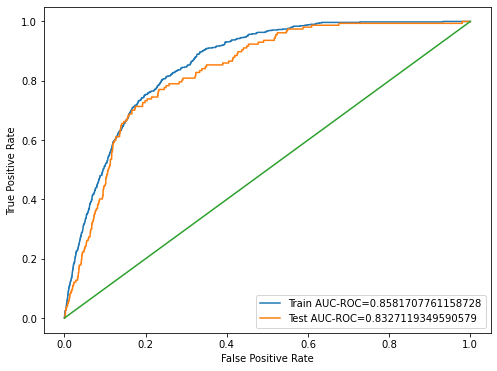

In [49]:
# Plot the ROC-AUC Curve
plt.figure(figsize=(8,6)) 
plt.plot(fpr_train, tpr_train, label="Train AUC-ROC="+str(auc_train))
plt.plot(fpr_test, tpr_test, label="Test AUC-ROC="+str(auc_test))

x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [50]:
# Calculate the precision-recall curve
t_precision, t_recall, t_thresholds = precision_recall_curve(y_test, y_test_pred_proba)
tr_precision, tr_recall, tr_thresholds = precision_recall_curve(y_train, y_train_pred_proba)

from sklearn import metrics
# Calculate the precision-recall AUC
t_auc = metrics.auc(t_recall, t_precision)
tr_auc = metrics.auc(tr_recall, tr_precision)

#Calculate 
test_f1 = f1_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)

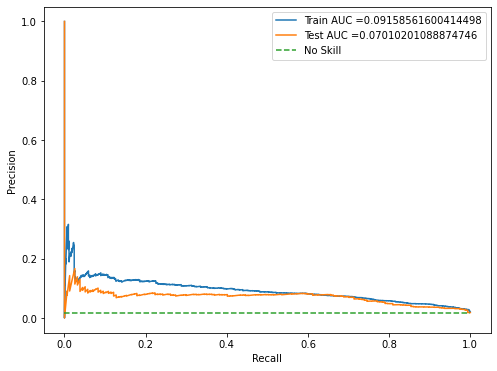

In [51]:
# Plot the PR Curve
plt.figure(figsize=(8,6)) 
plt.plot(tr_recall, tr_precision, label="Train AUC ="+str(tr_auc))
plt.plot(t_recall, t_precision, label="Test AUC ="+str(t_auc))

x = np.linspace(0, 1, 1000)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.xlabel('Recall') 
plt.ylabel('Precision') 
plt.legend() 
plt.show()

# Cross Validation

In [30]:
# Let's perform cross-validation
def cv_score(ml_model, rstate = 12, thres = 0.5, cols = X.columns):
    i = 1
    cv_scores = []
    df1 = X.copy()
    df1 = X[cols]
    
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    
    for df_index,test_index in kf.split(df1,y):
        xtr,xvl = df1.loc[df_index],df1.loc[test_index]
        ytr,yvl = y.loc[df_index],y.loc[test_index]
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        pp = []
         
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
         
        # Calculate scores for each fold and print
        pred_val = pp
        
        roc_score = roc_auc_score(yvl,pred_probs[:,1])
        recall = recall_score(yvl,pred_val)
        precision = precision_score(yvl,pred_val)
        f1score = f1_score(yvl,pred_val)
        
        sufix = ""
        msg = ""
        msg += "ROC AUC Score: {}, Recall Score: {:.4f}, Precision Score: {:.4f}, F1 Score: {:.4f} ".format(roc_score, recall,precision, f1score)
         
         # Save scores
        cv_scores.append(roc_score)
        i+=1
    print('Mean AUC_ROC_Score - ' ,np.mean(cv_scores))
    return cv_scores

In [31]:
cv_scores_with_weights = cv_score(LogisticRegression(class_weight={0:0.04, 1:0.96}))

Mean AUC_ROC_Score -  0.8526857002000036


In [32]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
n_scores = cross_val_score(LogisticRegression(class_weight='balanced'), X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
# report model performance
n_scores
print('ROC_AUC_Score Mean: {:.5f}'.format(n_scores.mean()))

ROC_AUC_Score Mean: 0.85274


In [33]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
n_scores = cross_val_score(LogisticRegression(class_weight={0:0.04, 1:0.96}), X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
# report model performance
n_scores
print('ROC_AUC_Score Mean: {:.5f}'.format(n_scores.mean()))

ROC_AUC_Score Mean: 0.85309


# Predict the test data

In [52]:
##################### MAKE PREDICTIONS FOR THE TEST SET ###########################
data_test.head()

,age,avg_glucose_level,bmi,age_bmi_gulcose,avg_glucose_level_age_ratio,bmi_age_ratio,hypertension,heart_disease,gender_Male,gender_Other,...,married_Self-employed,married_never_smoked,married_Urban,married_Male,married_obese,married_over_weight,married_diabetic,married_no_heartdisease,obese_diabetic,over_weight_diabetic
0,1.684326,-0.482246,-0.975457,0.179456,-0.179006,-0.228393,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.417983,1.763001,-0.333478,1.884605,-0.144626,-0.215327,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.245438,-0.216553,-0.962355,-0.804756,-0.035535,-0.041875,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.623973,-0.225941,-0.674120,-0.519843,-0.120704,-0.143084,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.929689,-0.488583,-0.123853,-0.014754,-0.172056,-0.202389,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Scale the numerical columns
cols = ['age', 'avg_glucose_level', 'bmi', 'age_bmi_gulcose', 'avg_glucose_level_age_ratio', 'bmi_age_ratio']
test_scaled = scale_data(data_test, cols, 'StandardScaler')

# Merge the 3 scaled columns with x_train & x_test
X_orig = data_test.drop(cols, axis = 1)
data_test = pd.merge(test_scaled, X_orig, left_index=True, right_index=True)

In [54]:
if best_features != "":
    data_test = data_test[best_features]
else:
    data_test = data_test.drop(['id','index'], axis=1)
    
pred_proba = lr.predict_proba(data_test)
ss = pd.read_csv('sample_submission_pwrF8gb.csv')
ss['stroke'] = pred_proba[:,-1]
ss.to_csv('pred_stroke_final.csv', index=False)

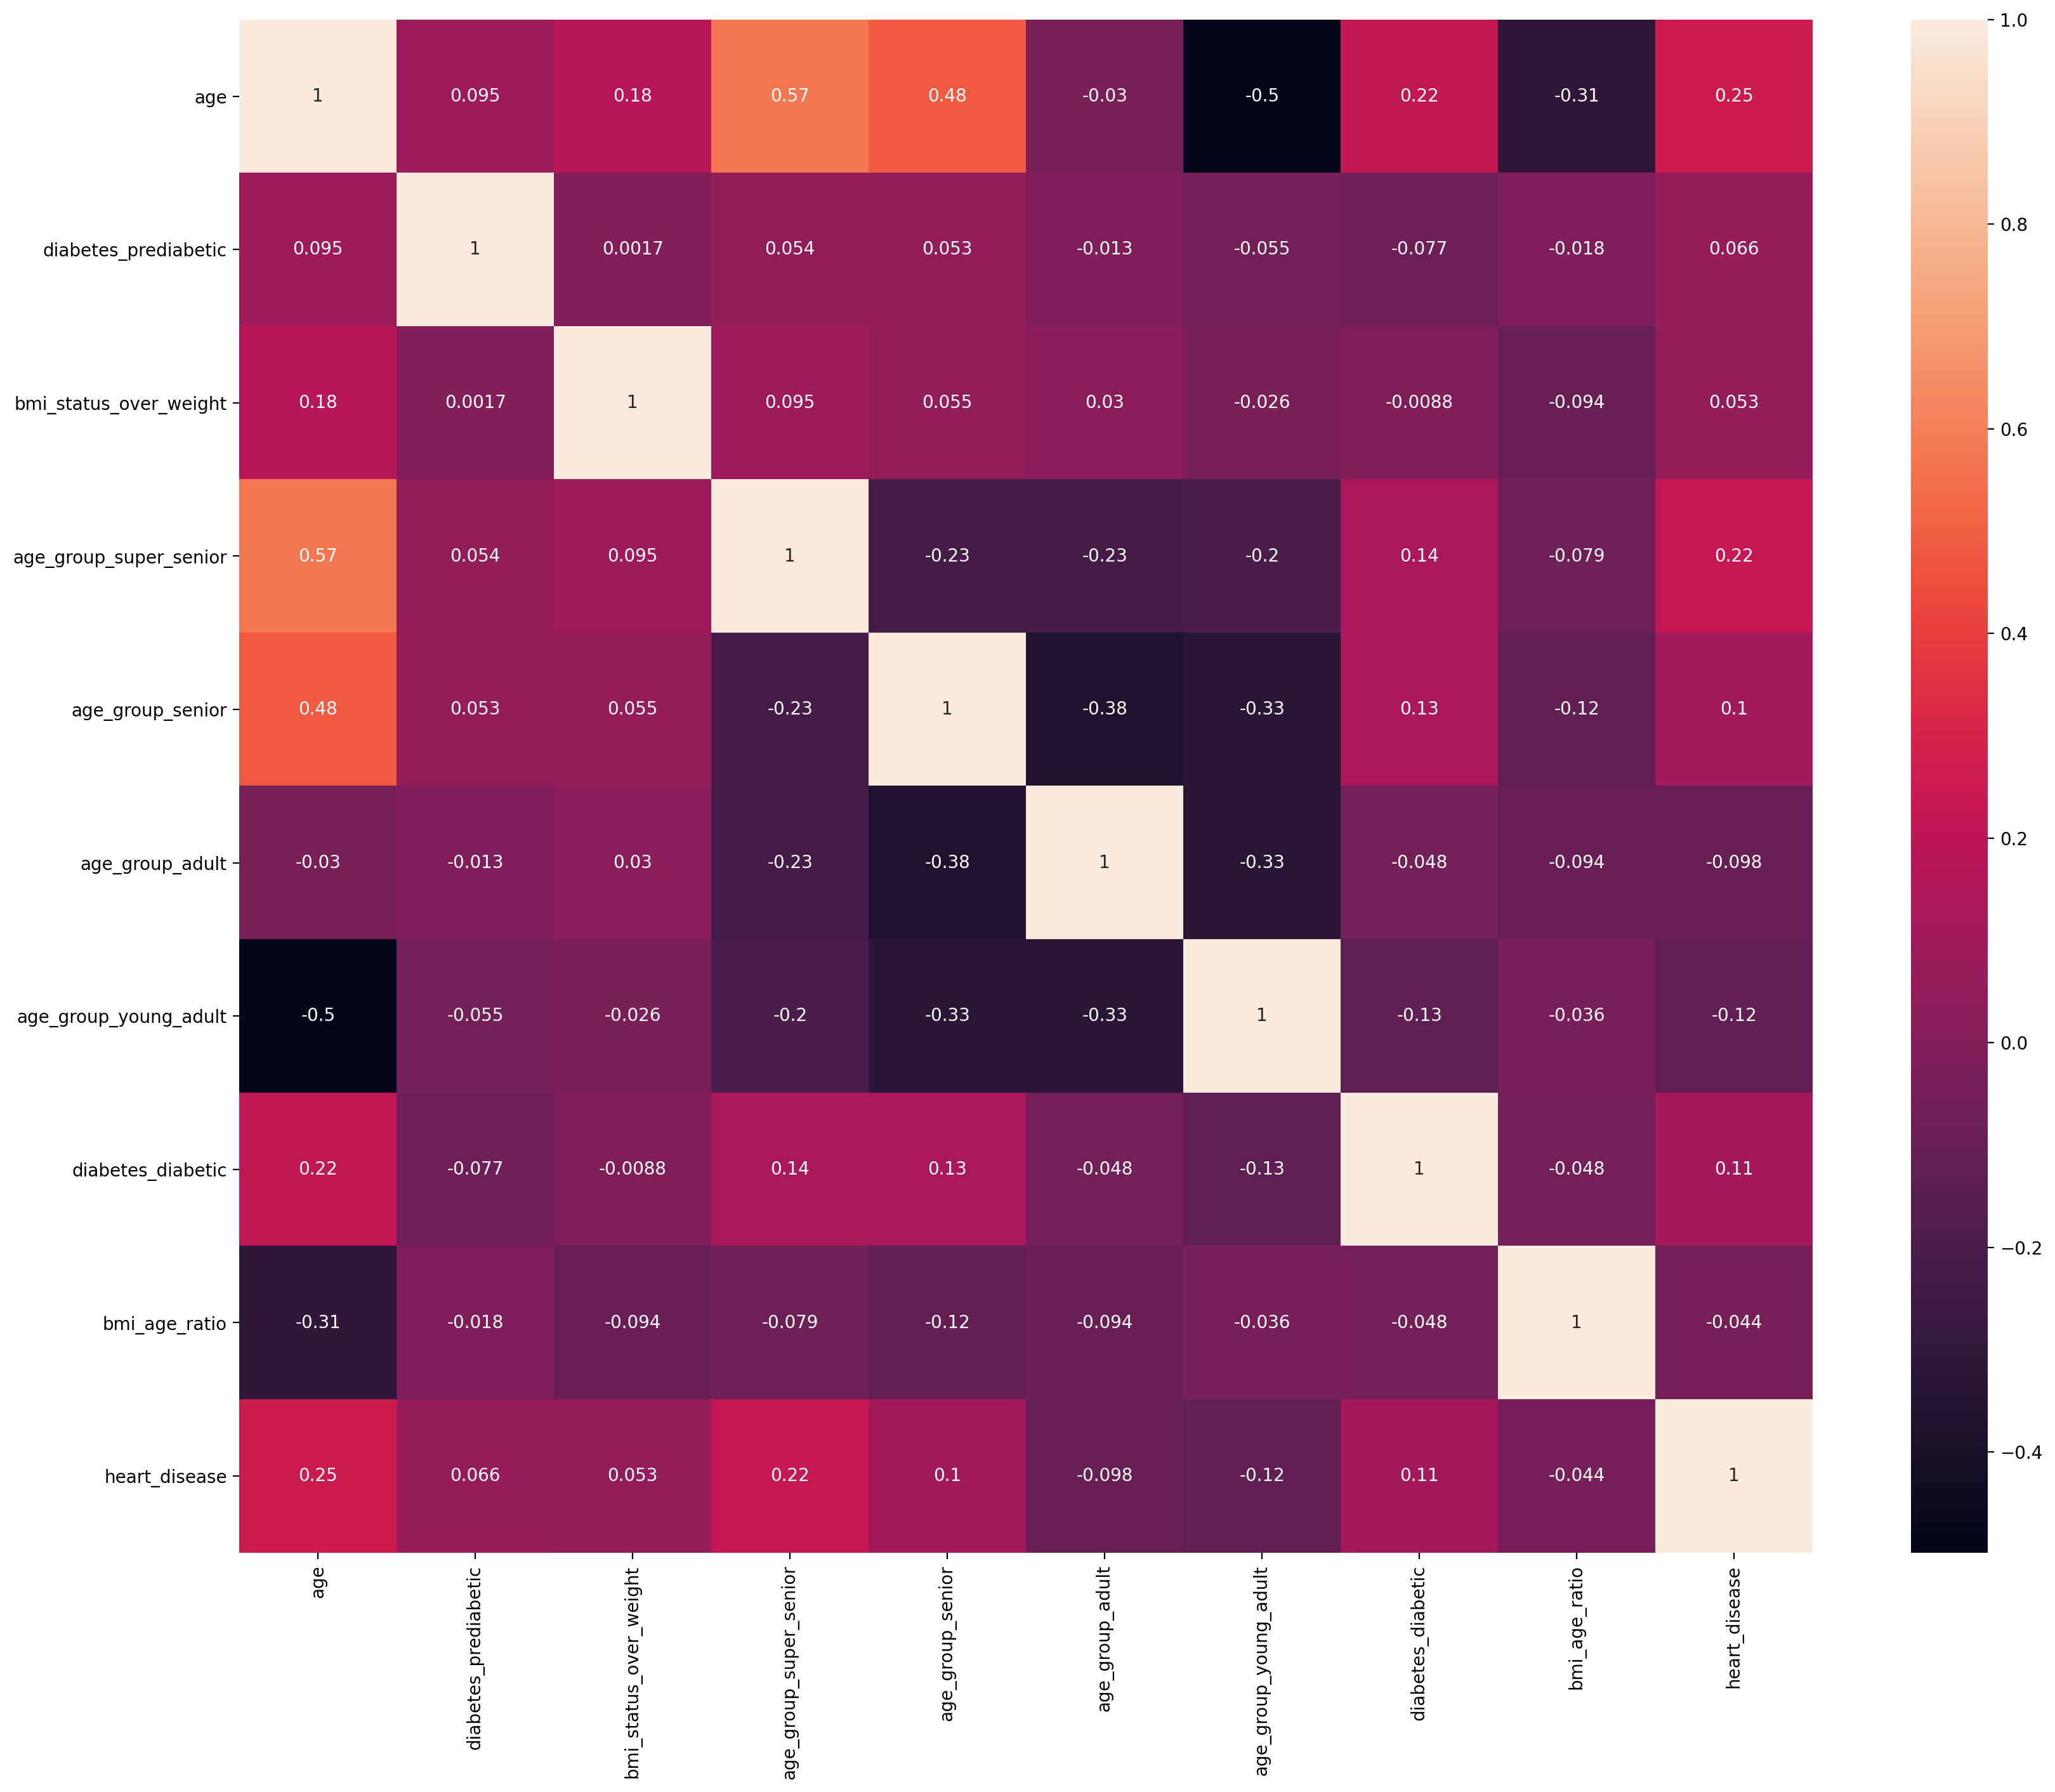

In [55]:
# Plot the correlation heatmap
plt.figure(figsize=(20,16), dpi =200)
sns.heatmap(data_test.corr(), annot = True);

<AxesSubplot:title={'center':'Model Coefficients'}>

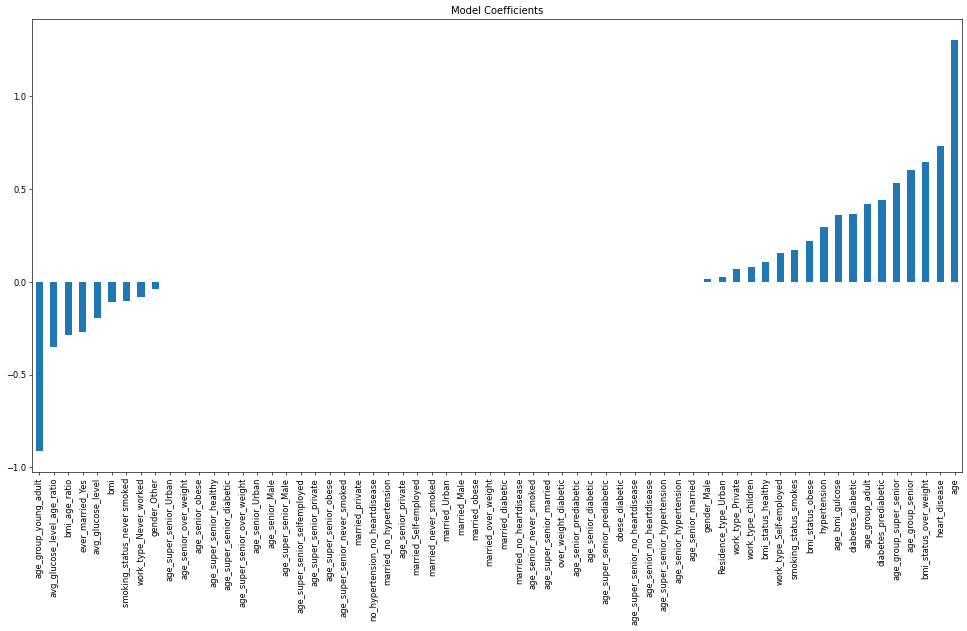

In [38]:
# Plot the model coefficient map
from pandas import Series
plt.figure(figsize=(20, 10), dpi=60, facecolor='w', edgecolor='b')
predictors = data_test.columns
coef = Series(lr.coef_.reshape(-1),predictors).sort_values()
coef.plot(kind='bar', title='Model Coefficients')


# Feature Selection - RFE

In [39]:
from sklearn.feature_selection import RFE

# Create the RFE object and rank each feature
model = LogisticRegression(class_weight = {0:0.04, 1:0.96})
rfe = RFE(estimator=model, n_features_to_select=10, step=1)
rfe.fit(x_train, y_train)

RFE(estimator=LogisticRegression(class_weight={0: 0.04, 1: 0.96}),
    n_features_to_select=10)

In [40]:
ranking_df = pd.DataFrame()
ranking_df['Feature_name'] = x_train.columns
ranking_df['Rank'] = rfe.ranking_
ranked = ranking_df.sort_values(by=['Rank'])
ranked.head(20)

,Feature_name,Rank
0,age,1
25,diabetes_prediabetic,1
23,bmi_status_over_weight,1
21,age_group_super_senior,1
20,age_group_senior,1
19,age_group_adult,1
18,age_group_young_adult,1
26,diabetes_diabetic,1
5,bmi_age_ratio,1
7,heart_disease,1


In [56]:
# Cross validation using the rfe top 10 features
rfe_top_10_scores = cv_score(LogisticRegression(class_weight={0:0.04, 1:0.96}), cols = ranked['Feature_name'][:10].values)

Mean AUC_ROC_Score -  0.8524888135042182


# Feature Selection - SFS

In [42]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
sfs1 = sfs(lr, k_features=10, forward=True, verbose=2, scoring='recall')

In [43]:
sfs1 = sfs1.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   11.9s finished

[2021-02-14 12:05:41] Features: 1/10 -- score: 0.5959111111111112[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:   14.1s finished

[2021-02-14 12:05:56] Features: 2/10 -- score: 0.6390603174603174[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:   16.5s finished

[2021-02-14 12:06:12] Features: 3/10 -- score: 0.6517714285714284[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [44]:
feat_names = list(sfs1.k_feature_names_)

In [45]:
# Cross validation using the SFS top 10 features
sfs_top_10_scores = cv_score(LogisticRegression(class_weight={0:0.04, 1:0.96}), cols = feat_names)

Mean AUC_ROC_Score -  0.841662036582979


Observations:
Based on the various cross validation scores, the best AUC_ROC_Score was achieved using RFE top 10 rank features. Let's use these columns to build the final model now.

In [46]:
# Update the best_features list so that the model can be optimized for these features
best_features = list(ranked['Feature_name'][:10].values)